순환 신경망 모델은 순차적인 자료에서 규칙적인 패턴을 인식하거나 그 의미를 추론할 수 있다.<br>
순차적이라는 특성 때문에 간단한 레이어로도 다양한 형태의 모델을 구성할 수 있다.<br>
케라스에서 제공하는 순환 신경망 레이어 : SimpleRNN, GRU, LSTM이 있으나 주로 LSTM을 사용한다.

# 1. 긴 시퀀스를 기억할 수 있는 LSTM(Long Short-Term Memory units) 레이어
LSTM 레이어는 아래와 같이 간단히 사용할 수 있다.<br>
- 입력 형태
 
    LSTM(3, input_dim=1)
  
기본 인자 : <br>
1. 1번째 인자 : 메모리 셀의 개수
2. 2번째 인자 : 입력 속성 수

Dense 레이어 형태와 비슷하다.<br>
첫번째 인자인 메모리 셀의 개수는 기억용량 정도와 출력 형태를 결정짓는다. = Dense 레이어에서의 출력 뉴런 수와 비슷<br>
input_dim은 Dense 레이어와 같이 일반적으로 속성의 개수가 들어간다.<br>
    
    Dense(3, input_dim=1)
    
LSTM의 한 가지 인자에 대해 더 알아보겠다.<br>
 
    LSTM(3, input_dim=1, input_length=4)
    
- input_length : 시퀀스 데이터의 입력 길이

Dense와 LSTM 도식화 참고(p.146)<br>
LSTM는 Dense와 비교하면 뉴련들이 튀어나와 있다.<br>
input_length가 길다고 해서 각 입력마다 다른 가중치가 사용하는 것이 입력 길이 만큼 연결한 것이기 때문에 모두 동일한 가중치를 공유함.<br>

- 출력 형태 : return_sequences : 시퀀스 출력 여부

LSTM 레이어는 return_sequences 인자에 따라 마지막 시퀀스에서 한 번만 출력할 수 있고 가가 시퀀스에서 출력할 수 있다.<br>
Many to many 문제를 풀거나 LSTM 레이어를 여러 개로 쌓아 올릴 때는 return_sequences=True 옵션을 사용한다.<br>
return_sequences=True -> 출력값이 여러 개, return_sequences=False -> 출력값이 1개<br>

- 상태유지(stateful) 모드 : stateful : 상태 유지 여부

학습 샘플의 가장 마지막 상태가 다음 샘플 학습 시에 입력으로 전달 여부를 지정하는 것<br>
하나의 샘플은 4개의 시퀀스 입력이 있고 총 3개의 샘플 있을 때(p.148 참고)<br>
- stateful=True일 때 : 도출된 현재 상태의 가중치가 다음 샘플 학습 시의 초기 상태로 입력됨
- stateful=False일 때 : 도출된 현재 상태의 가중치가 다음 샘플 학습 시의 초기 상태로 입력되지 않음


# 2. 순환 신경망 모델 만들기

### 1. 시퀀스 데이터 준비
순환 신경망은 주로 자연어 처리에 많이 쓰인다. -> 문장 학습 예제가 일반적이다. 예제는 악보로 하겠다.<br>
악보 학습이 더 쉬운 이유는<br> 
- 음계가 문장보다 더 코드화하기 쉽다.
- 시계열 자료이다.
- 나온 결과를 악보로 볼 수 있다.
- 우리가 학습한 모델이 연주하는 곡을 들어볼 수 있기 때문이다.

여기서 예제는 나비야로 하겠다.

### 2. 데이터셋 생성
각 샘플은 4개의 입력 데이터와 1개의 라벨값으로 구성되어 있다.<br>
즉 1~4번째 열은 속성(feature)이고, 5번째 열은 클래스(class)를 나타낸다.<br>
이렇게 4개씩 구간을 보는 것을 **윈도우 크기**가 4라고 한다.<br>
문자와 숫자로 된 음표(코드)로는 모델 입출력으로 사용할 수 없기 때문에 각 코드를 숫자로 변환할 수 있는 사전을 만들어본다.<br>
첫번째 사전은 코드를 숫자로, 두번째 사전은 숫자를 코드로 만드는 코드입니다.<br>

In [1]:
code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

이러한 사전을 이용해서 순차적인 음표를 우리가 지정한 윈도우 크기만큼 잘라 데이터셋을 생성하는 함수를 정의해본다.

In [2]:
import numpy as np

def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

seq라는 변수에 “나비야” 곡 전체 음표를 저장한 다음, seq2dataset() 함수를 하여 dataset를 생성한다.

In [3]:
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
print(dataset)

(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]


### 3. 학습과정
첫 4개 음표를 입력하면 나머지를 연주할 수 있게 만드는 모델을 만드는 것이 목표이다.<br>
학습시키는 방식은 아래와 같다.<br>
- 1~4번째 음표를 데이터로, 5번째 음표를 라벨값으로 학습시킨다.
- 다음에는 2~5번째 음표를, 데이터로 6번째 음표를 라벨값으로 학습시킨다.
- 이후 한 음표씩 넘어가면서 노래를 끝까지 학습시킨다.

### 4. 예측 과정
- 한 스텝 예측
한 스텝 예측이란 실제 음표 4개를 입력하여 다음 음표 1개를 예측하는 과정을 반복하는 것이다.<br>
이 방법에서는 모델의 입력값으로는 항상 실제 음표가 들어간다.<br>
    - 모델에 t0,t1,t2,t3를 입력하면 y0 출력이 나온다.
    - 모델에 t1,t2,t3,t4를 입력하면 y1 출력이 나온다.
    - 모델에 t2,t3,t4,t5를 입력하면 y2 출력이 나온다.
    - 이 과정을 y49 출력까지 반복한다.
    
- 곡 전체 예측
곡 전체 예측이란 입력된 초가 4개 음표만을 입력으로 곡 전체를 예측하는 것이다.<br>
초반부가 지나면 예측값만으로 모델에 입력되어 다음 예측값이 나오는 식이다.<br>
그야말로 "나비야~ 나"까지 알려주면 나머지까지 모두 연주를 하는 것이다.<br>
만약 중간에 틀린 부분이 있다면, 이후 음정과 박자는 모두 이상하게 될 가능이 많다. 즉 예측 오류가 누적되는 것이다.<br>
    - 모델에 t0,t1,t2,t3를 입력하면 y0 출력이 나온다.
    - 예측값인 y0를 t4라고 가정하고, 모델에 t1,t2,t3,t4를 입력하면 y1 출력이 나온다.
    - 예측값인 y1를 t5라고 가정하고,모델에 t2,t3,t4(예측값),t5(예측값)를 입력하면 y2 출력이 나온다.
    - 이 과정을 y49 출력까지 반복한다.

### 5. 다층 퍼셉트론 신경망 모델
앞서 생성한 데이터셋으로 먼저 다층 퍼셉트론 모델을 학습시켜본다.<br>
 Dense 레이어 3개로 구성하였고, 입력 속성이 4개이고 출력이 12개(one_hot_vec_size=12)으로 설정했다.<br>

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import numpy as np

one_hot_vec_size=12

model = Sequential()
model.add(Dense(128, input_dim=4, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(one_hot_vec_size, activation='softmax'))

전체 소스는 아래와 같다.

(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]
('one hot encoding vector size is ', 12)


Instructions for updating:
Use tf.where in 2.0, 

Epoch 101/2000
 - 0s - loss: 1.3975 - acc: 0.5200
Epoch 102/2000
 - 0s - loss: 1.3995 - acc: 0.5000
Epoch 103/2000
 - 0s - loss: 1.4000 - acc: 0.5000
Epoch 104/2000
 - 0s - loss: 1.3903 - acc: 0.5200
Epoch 105/2000
 - 0s - loss: 1.3863 - acc: 0.5200
Epoch 106/2000
 - 0s - loss: 1.3835 - acc: 0.5200
Epoch 107/2000
 - 0s - loss: 1.3877 - acc: 0.5000
Epoch 108/2000
 - 0s - loss: 1.3823 - acc: 0.5200
Epoch 109/2000
 - 0s - loss: 1.3851 - acc: 0.5000
Epoch 110/2000
 - 0s - loss: 1.3759 - acc: 0.5400
Epoch 111/2000
 - 0s - loss: 1.3775 - acc: 0.5200
Epoch 112/2000
 - 0s - loss: 1.3754 - acc: 0.5000
Epoch 113/2000
 - 0s - loss: 1.3770 - acc: 0.5000
Epoch 114/2000
 - 0s - loss: 1.3692 - acc: 0.5200
Epoch 115/2000
 - 0s - loss: 1.3634 - acc: 0.5200
Epoch 116/2000
 - 0s - loss: 1.3676 - acc: 0.5400
Epoch 117/2000
 - 0s - loss: 1.3563 - acc: 0.5400
Epoch 118/2000
 - 0s - loss: 1.3607 - acc: 0.5000
Epoch 119/2000
 - 0s - loss: 1.3550 - acc: 0.5200
Epoch 120/2000
 - 0s - loss: 1.3493 - acc: 0.5200


Epoch 265/2000
 - 0s - loss: 1.0758 - acc: 0.5800
Epoch 266/2000
 - 0s - loss: 1.0825 - acc: 0.5800
Epoch 267/2000
 - 0s - loss: 1.0708 - acc: 0.6000
Epoch 268/2000
 - 0s - loss: 1.0697 - acc: 0.5800
Epoch 269/2000
 - 0s - loss: 1.0704 - acc: 0.5800
Epoch 270/2000
 - 0s - loss: 1.0718 - acc: 0.5800
Epoch 271/2000
 - 0s - loss: 1.0662 - acc: 0.5800
Epoch 272/2000
 - 0s - loss: 1.0728 - acc: 0.5800
Epoch 273/2000
 - 0s - loss: 1.0656 - acc: 0.6000
Epoch 274/2000
 - 0s - loss: 1.0689 - acc: 0.5800
Epoch 275/2000
 - 0s - loss: 1.0691 - acc: 0.5800
Epoch 276/2000
 - 0s - loss: 1.0686 - acc: 0.5800
Epoch 277/2000
 - 0s - loss: 1.0601 - acc: 0.6000
Epoch 278/2000
 - 0s - loss: 1.0580 - acc: 0.5800
Epoch 279/2000
 - 0s - loss: 1.0590 - acc: 0.5800
Epoch 280/2000
 - 0s - loss: 1.0569 - acc: 0.5800
Epoch 281/2000
 - 0s - loss: 1.0521 - acc: 0.5800
Epoch 282/2000
 - 0s - loss: 1.0549 - acc: 0.5800
Epoch 283/2000
 - 0s - loss: 1.0572 - acc: 0.5800
Epoch 284/2000
 - 0s - loss: 1.0541 - acc: 0.6000


Epoch 429/2000
 - 0s - loss: 0.8939 - acc: 0.6800
Epoch 430/2000
 - 0s - loss: 0.8891 - acc: 0.6200
Epoch 431/2000
 - 0s - loss: 0.8928 - acc: 0.6400
Epoch 432/2000
 - 0s - loss: 0.8958 - acc: 0.6400
Epoch 433/2000
 - 0s - loss: 0.8922 - acc: 0.6800
Epoch 434/2000
 - 0s - loss: 0.8948 - acc: 0.6400
Epoch 435/2000
 - 0s - loss: 0.9051 - acc: 0.6400
Epoch 436/2000
 - 0s - loss: 0.8908 - acc: 0.6200
Epoch 437/2000
 - 0s - loss: 0.8863 - acc: 0.6800
Epoch 438/2000
 - 0s - loss: 0.8917 - acc: 0.6800
Epoch 439/2000
 - 0s - loss: 0.8887 - acc: 0.6600
Epoch 440/2000
 - 0s - loss: 0.8823 - acc: 0.6600
Epoch 441/2000
 - 0s - loss: 0.8902 - acc: 0.6400
Epoch 442/2000
 - 0s - loss: 0.8877 - acc: 0.6400
Epoch 443/2000
 - 0s - loss: 0.8861 - acc: 0.6800
Epoch 444/2000
 - 0s - loss: 0.8818 - acc: 0.6800
Epoch 445/2000
 - 0s - loss: 0.8835 - acc: 0.6600
Epoch 446/2000
 - 0s - loss: 0.8807 - acc: 0.6600
Epoch 447/2000
 - 0s - loss: 0.8803 - acc: 0.6600
Epoch 448/2000
 - 0s - loss: 0.8840 - acc: 0.6600


Epoch 593/2000
 - 0s - loss: 0.7547 - acc: 0.7400
Epoch 594/2000
 - 0s - loss: 0.7532 - acc: 0.7600
Epoch 595/2000
 - 0s - loss: 0.7558 - acc: 0.7000
Epoch 596/2000
 - 0s - loss: 0.7586 - acc: 0.7400
Epoch 597/2000
 - 0s - loss: 0.7507 - acc: 0.7400
Epoch 598/2000
 - 0s - loss: 0.7554 - acc: 0.7200
Epoch 599/2000
 - 0s - loss: 0.7576 - acc: 0.7000
Epoch 600/2000
 - 0s - loss: 0.7519 - acc: 0.7400
Epoch 601/2000
 - 0s - loss: 0.7515 - acc: 0.7200
Epoch 602/2000
 - 0s - loss: 0.7518 - acc: 0.7000
Epoch 603/2000
 - 0s - loss: 0.7479 - acc: 0.7200
Epoch 604/2000
 - 0s - loss: 0.7528 - acc: 0.7400
Epoch 605/2000
 - 0s - loss: 0.7469 - acc: 0.7400
Epoch 606/2000
 - 0s - loss: 0.7478 - acc: 0.7600
Epoch 607/2000
 - 0s - loss: 0.7600 - acc: 0.7200
Epoch 608/2000
 - 0s - loss: 0.7445 - acc: 0.7200
Epoch 609/2000
 - 0s - loss: 0.7444 - acc: 0.7000
Epoch 610/2000
 - 0s - loss: 0.7453 - acc: 0.7400
Epoch 611/2000
 - 0s - loss: 0.7472 - acc: 0.7400
Epoch 612/2000
 - 0s - loss: 0.7430 - acc: 0.7600


Epoch 757/2000
 - 0s - loss: 0.6642 - acc: 0.7400
Epoch 758/2000
 - 0s - loss: 0.6411 - acc: 0.8000
Epoch 759/2000
 - 0s - loss: 0.6432 - acc: 0.8000
Epoch 760/2000
 - 0s - loss: 0.6406 - acc: 0.8000
Epoch 761/2000
 - 0s - loss: 0.6390 - acc: 0.7400
Epoch 762/2000
 - 0s - loss: 0.6493 - acc: 0.7800
Epoch 763/2000
 - 0s - loss: 0.6404 - acc: 0.7800
Epoch 764/2000
 - 0s - loss: 0.6355 - acc: 0.7600
Epoch 765/2000
 - 0s - loss: 0.6396 - acc: 0.7800
Epoch 766/2000
 - 0s - loss: 0.6329 - acc: 0.8000
Epoch 767/2000
 - 0s - loss: 0.6320 - acc: 0.8000
Epoch 768/2000
 - 0s - loss: 0.6306 - acc: 0.8000
Epoch 769/2000
 - 0s - loss: 0.6297 - acc: 0.8000
Epoch 770/2000
 - 0s - loss: 0.6339 - acc: 0.8200
Epoch 771/2000
 - 0s - loss: 0.6238 - acc: 0.8000
Epoch 772/2000
 - 0s - loss: 0.6272 - acc: 0.7800
Epoch 773/2000
 - 0s - loss: 0.6263 - acc: 0.7800
Epoch 774/2000
 - 0s - loss: 0.6254 - acc: 0.8000
Epoch 775/2000
 - 0s - loss: 0.6283 - acc: 0.8000
Epoch 776/2000
 - 0s - loss: 0.6257 - acc: 0.7800


Epoch 921/2000
 - 0s - loss: 0.5410 - acc: 0.8000
Epoch 922/2000
 - 0s - loss: 0.5331 - acc: 0.8400
Epoch 923/2000
 - 0s - loss: 0.5313 - acc: 0.8200
Epoch 924/2000
 - 0s - loss: 0.5305 - acc: 0.8200
Epoch 925/2000
 - 0s - loss: 0.5327 - acc: 0.8200
Epoch 926/2000
 - 0s - loss: 0.5411 - acc: 0.7800
Epoch 927/2000
 - 0s - loss: 0.5253 - acc: 0.8200
Epoch 928/2000
 - 0s - loss: 0.5259 - acc: 0.8200
Epoch 929/2000
 - 0s - loss: 0.5224 - acc: 0.8600
Epoch 930/2000
 - 0s - loss: 0.5210 - acc: 0.8400
Epoch 931/2000
 - 0s - loss: 0.5196 - acc: 0.8200
Epoch 932/2000
 - 0s - loss: 0.5246 - acc: 0.8200
Epoch 933/2000
 - 0s - loss: 0.5176 - acc: 0.8200
Epoch 934/2000
 - 0s - loss: 0.5169 - acc: 0.8400
Epoch 935/2000
 - 0s - loss: 0.5206 - acc: 0.8400
Epoch 936/2000
 - 0s - loss: 0.5180 - acc: 0.8200
Epoch 937/2000
 - 0s - loss: 0.5178 - acc: 0.8400
Epoch 938/2000
 - 0s - loss: 0.5161 - acc: 0.8600
Epoch 939/2000
 - 0s - loss: 0.5193 - acc: 0.8200
Epoch 940/2000
 - 0s - loss: 0.5153 - acc: 0.8200


Epoch 1084/2000
 - 0s - loss: 0.4369 - acc: 0.8800
Epoch 1085/2000
 - 0s - loss: 0.4641 - acc: 0.8600
Epoch 1086/2000
 - 0s - loss: 0.4392 - acc: 0.9200
Epoch 1087/2000
 - 0s - loss: 0.4453 - acc: 0.9000
Epoch 1088/2000
 - 0s - loss: 0.4506 - acc: 0.8600
Epoch 1089/2000
 - 0s - loss: 0.4478 - acc: 0.8800
Epoch 1090/2000
 - 0s - loss: 0.4340 - acc: 0.9000
Epoch 1091/2000
 - 0s - loss: 0.4357 - acc: 0.8800
Epoch 1092/2000
 - 0s - loss: 0.4326 - acc: 0.9000
Epoch 1093/2000
 - 0s - loss: 0.4377 - acc: 0.9000
Epoch 1094/2000
 - 0s - loss: 0.4347 - acc: 0.9200
Epoch 1095/2000
 - 0s - loss: 0.4278 - acc: 0.9000
Epoch 1096/2000
 - 0s - loss: 0.4322 - acc: 0.9200
Epoch 1097/2000
 - 0s - loss: 0.4307 - acc: 0.9000
Epoch 1098/2000
 - 0s - loss: 0.4315 - acc: 0.9200
Epoch 1099/2000
 - 0s - loss: 0.4355 - acc: 0.9200
Epoch 1100/2000
 - 0s - loss: 0.4284 - acc: 0.9000
Epoch 1101/2000
 - 0s - loss: 0.4311 - acc: 0.8800
Epoch 1102/2000
 - 0s - loss: 0.4294 - acc: 0.8800
Epoch 1103/2000
 - 0s - loss: 0

Epoch 1245/2000
 - 0s - loss: 0.3660 - acc: 0.9200
Epoch 1246/2000
 - 0s - loss: 0.3711 - acc: 0.9200
Epoch 1247/2000
 - 0s - loss: 0.3688 - acc: 0.9200
Epoch 1248/2000
 - 0s - loss: 0.3710 - acc: 0.9200
Epoch 1249/2000
 - 0s - loss: 0.3690 - acc: 0.9200
Epoch 1250/2000
 - 0s - loss: 0.3715 - acc: 0.9200
Epoch 1251/2000
 - 0s - loss: 0.3751 - acc: 0.9000
Epoch 1252/2000
 - 0s - loss: 0.3707 - acc: 0.9200
Epoch 1253/2000
 - 0s - loss: 0.3651 - acc: 0.9200
Epoch 1254/2000
 - 0s - loss: 0.3658 - acc: 0.9200
Epoch 1255/2000
 - 0s - loss: 0.3703 - acc: 0.9200
Epoch 1256/2000
 - 0s - loss: 0.3624 - acc: 0.9200
Epoch 1257/2000
 - 0s - loss: 0.3736 - acc: 0.9200
Epoch 1258/2000
 - 0s - loss: 0.3637 - acc: 0.9200
Epoch 1259/2000
 - 0s - loss: 0.3681 - acc: 0.9200
Epoch 1260/2000
 - 0s - loss: 0.3641 - acc: 0.9200
Epoch 1261/2000
 - 0s - loss: 0.3745 - acc: 0.9000
Epoch 1262/2000
 - 0s - loss: 0.3673 - acc: 0.9200
Epoch 1263/2000
 - 0s - loss: 0.3673 - acc: 0.9200
Epoch 1264/2000
 - 0s - loss: 0

Epoch 1406/2000
 - 0s - loss: 0.3199 - acc: 0.9200
Epoch 1407/2000
 - 0s - loss: 0.3296 - acc: 0.9200
Epoch 1408/2000
 - 0s - loss: 0.3218 - acc: 0.9200
Epoch 1409/2000
 - 0s - loss: 0.3228 - acc: 0.9200
Epoch 1410/2000
 - 0s - loss: 0.3221 - acc: 0.9200
Epoch 1411/2000
 - 0s - loss: 0.3335 - acc: 0.9000
Epoch 1412/2000
 - 0s - loss: 0.3551 - acc: 0.9000
Epoch 1413/2000
 - 0s - loss: 0.3184 - acc: 0.9200
Epoch 1414/2000
 - 0s - loss: 0.3280 - acc: 0.9200
Epoch 1415/2000
 - 0s - loss: 0.3250 - acc: 0.9000
Epoch 1416/2000
 - 0s - loss: 0.3182 - acc: 0.9200
Epoch 1417/2000
 - 0s - loss: 0.3138 - acc: 0.9200
Epoch 1418/2000
 - 0s - loss: 0.3290 - acc: 0.9000
Epoch 1419/2000
 - 0s - loss: 0.3069 - acc: 0.9200
Epoch 1420/2000
 - 0s - loss: 0.3202 - acc: 0.9200
Epoch 1421/2000
 - 0s - loss: 0.3229 - acc: 0.9200
Epoch 1422/2000
 - 0s - loss: 0.3206 - acc: 0.9200
Epoch 1423/2000
 - 0s - loss: 0.3140 - acc: 0.9200
Epoch 1424/2000
 - 0s - loss: 0.3092 - acc: 0.9200
Epoch 1425/2000
 - 0s - loss: 0

Epoch 1567/2000
 - 0s - loss: 0.2786 - acc: 0.9200
Epoch 1568/2000
 - 0s - loss: 0.2824 - acc: 0.9200
Epoch 1569/2000
 - 0s - loss: 0.2798 - acc: 0.9200
Epoch 1570/2000
 - 0s - loss: 0.2801 - acc: 0.9200
Epoch 1571/2000
 - 0s - loss: 0.2813 - acc: 0.9200
Epoch 1572/2000
 - 0s - loss: 0.2844 - acc: 0.9200
Epoch 1573/2000
 - 0s - loss: 0.2766 - acc: 0.9200
Epoch 1574/2000
 - 0s - loss: 0.2930 - acc: 0.9200
Epoch 1575/2000
 - 0s - loss: 0.2881 - acc: 0.9000
Epoch 1576/2000
 - 0s - loss: 0.2854 - acc: 0.9200
Epoch 1577/2000
 - 0s - loss: 0.2741 - acc: 0.9200
Epoch 1578/2000
 - 0s - loss: 0.2836 - acc: 0.9200
Epoch 1579/2000
 - 0s - loss: 0.2762 - acc: 0.9200
Epoch 1580/2000
 - 0s - loss: 0.2764 - acc: 0.9200
Epoch 1581/2000
 - 0s - loss: 0.2724 - acc: 0.9200
Epoch 1582/2000
 - 0s - loss: 0.2812 - acc: 0.9200
Epoch 1583/2000
 - 0s - loss: 0.2771 - acc: 0.9200
Epoch 1584/2000
 - 0s - loss: 0.2747 - acc: 0.9200
Epoch 1585/2000
 - 0s - loss: 0.2762 - acc: 0.9200
Epoch 1586/2000
 - 0s - loss: 0

Epoch 1728/2000
 - 0s - loss: 0.2577 - acc: 0.9200
Epoch 1729/2000
 - 0s - loss: 0.2565 - acc: 0.9200
Epoch 1730/2000
 - 0s - loss: 0.2590 - acc: 0.9200
Epoch 1731/2000
 - 0s - loss: 0.2568 - acc: 0.9200
Epoch 1732/2000
 - 0s - loss: 0.2570 - acc: 0.9200
Epoch 1733/2000
 - 0s - loss: 0.2497 - acc: 0.9200
Epoch 1734/2000
 - 0s - loss: 0.2615 - acc: 0.9000
Epoch 1735/2000
 - 0s - loss: 0.2548 - acc: 0.9200
Epoch 1736/2000
 - 0s - loss: 0.2661 - acc: 0.9000
Epoch 1737/2000
 - 0s - loss: 0.2469 - acc: 0.9200
Epoch 1738/2000
 - 0s - loss: 0.2477 - acc: 0.9200
Epoch 1739/2000
 - 0s - loss: 0.2551 - acc: 0.9200
Epoch 1740/2000
 - 0s - loss: 0.2453 - acc: 0.9200
Epoch 1741/2000
 - 0s - loss: 0.2546 - acc: 0.9200
Epoch 1742/2000
 - 0s - loss: 0.2585 - acc: 0.9200
Epoch 1743/2000
 - 0s - loss: 0.2687 - acc: 0.9200
Epoch 1744/2000
 - 0s - loss: 0.2557 - acc: 0.9200
Epoch 1745/2000
 - 0s - loss: 0.2485 - acc: 0.9200
Epoch 1746/2000
 - 0s - loss: 0.2610 - acc: 0.9000
Epoch 1747/2000
 - 0s - loss: 0

Epoch 1889/2000
 - 0s - loss: 0.2326 - acc: 0.9200
Epoch 1890/2000
 - 0s - loss: 0.2351 - acc: 0.9200
Epoch 1891/2000
 - 0s - loss: 0.2356 - acc: 0.9200
Epoch 1892/2000
 - 0s - loss: 0.2292 - acc: 0.9200
Epoch 1893/2000
 - 0s - loss: 0.2240 - acc: 0.9200
Epoch 1894/2000
 - 0s - loss: 0.2344 - acc: 0.9000
Epoch 1895/2000
 - 0s - loss: 0.2246 - acc: 0.9200
Epoch 1896/2000
 - 0s - loss: 0.2471 - acc: 0.9200
Epoch 1897/2000
 - 0s - loss: 0.2375 - acc: 0.9200
Epoch 1898/2000
 - 0s - loss: 0.2378 - acc: 0.9000
Epoch 1899/2000
 - 0s - loss: 0.2306 - acc: 0.9200
Epoch 1900/2000
 - 0s - loss: 0.2294 - acc: 0.9200
Epoch 1901/2000
 - 0s - loss: 0.2315 - acc: 0.9200
Epoch 1902/2000
 - 0s - loss: 0.2324 - acc: 0.9200
Epoch 1903/2000
 - 0s - loss: 0.2358 - acc: 0.9000
Epoch 1904/2000
 - 0s - loss: 0.2271 - acc: 0.9200
Epoch 1905/2000
 - 0s - loss: 0.2330 - acc: 0.9200
Epoch 1906/2000
 - 0s - loss: 0.2392 - acc: 0.9200
Epoch 1907/2000
 - 0s - loss: 0.2398 - acc: 0.9000
Epoch 1908/2000
 - 0s - loss: 0

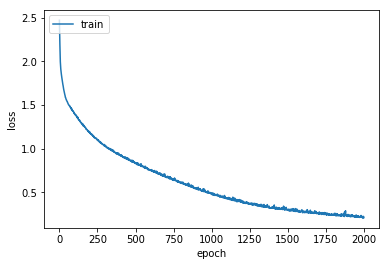

50/50 [==============================] - 0s 734us/step
acc: 92.00%
('one step prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'e8', 'd8', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4'])
('full song prediction : ', ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8'])


In [9]:
# 0. 사용할 패키지 불러오기
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import numpy as np

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
# 데이터셋 생성 함수        
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)


# 1. 데이터 준비하기

# 코드 사전 정의

code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

# 시퀀스 데이터 정의

seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

# 2. 데이터셋 생성하기
dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
print(dataset)


# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:4]
y_train = dataset[:,4]

max_idx_value = 13

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

# 3. 모델 구성하기
model = Sequential()
model.add(Dense(128, input_dim=4, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(one_hot_vec_size, activation='softmax'))

# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = LossHistory() # 손실 이력 객체 생성
history.init()

# 5. 모델 학습시키기
model.fit(x_train, y_train, epochs=2000, batch_size=10, verbose=2, callbacks=[history])
    
# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

# 8. 모델 사용하기

pred_count = 50 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4)) # batch_size, feature
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)

총 50개의 예측 중 4개를 틀려서 92% 정확도가 나왔다.<br>
중간에 틀린 부분이 생기면 곡 전체를 예측하는데 있어서 그리 좋은 성능이 나오지 않는다.

### 6. 기본 LSTM 모델